In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pubchempy as pcp

In [2]:
gdsc1 = pd.read_excel("GDSC1_fitted_dose_response_27Oct23.xlsx")
gdsc1.head()

,DATASET,NLME_RESULT_ID,NLME_CURVE_ID,COSMIC_ID,CELL_LINE_NAME,SANGER_MODEL_ID,TCGA_DESC,DRUG_ID,DRUG_NAME,PUTATIVE_TARGET,PATHWAY_NAME,COMPANY_ID,WEBRELEASE,MIN_CONC,MAX_CONC,LN_IC50,AUC,RMSE,Z_SCORE
0,GDSC1,342,15580432,684057,ES5,SIDM00263,UNCLASSIFIED,1,Erlotinib,EGFR,EGFR signaling,1045,Y,0.007813,2.0,3.966813,0.985678,0.026081,1.299144
1,GDSC1,342,15580806,684059,ES7,SIDM00269,UNCLASSIFIED,1,Erlotinib,EGFR,EGFR signaling,1045,Y,0.007813,2.0,2.692090,0.972690,0.110059,0.156076
2,GDSC1,342,15581198,684062,EW-11,SIDM00203,UNCLASSIFIED,1,Erlotinib,EGFR,EGFR signaling,1045,Y,0.007813,2.0,2.477990,0.944459,0.087019,-0.035912
3,GDSC1,342,15581542,684072,SK-ES-1,SIDM01111,UNCLASSIFIED,1,Erlotinib,EGFR,EGFR signaling,1045,Y,0.007813,2.0,2.033564,0.950758,0.016290,-0.434437
4,GDSC1,342,15581930,687448,COLO-829,SIDM00909,SKCM,1,Erlotinib,EGFR,EGFR signaling,1045,Y,0.007813,2.0,2.966007,0.954778,0.180255,0.401702


In [3]:
gdsc2 = pd.read_excel("GDSC2_fitted_dose_response_27Oct23.xlsx")
gdsc2.head()

,DATASET,NLME_RESULT_ID,NLME_CURVE_ID,COSMIC_ID,CELL_LINE_NAME,SANGER_MODEL_ID,TCGA_DESC,DRUG_ID,DRUG_NAME,PUTATIVE_TARGET,PATHWAY_NAME,COMPANY_ID,WEBRELEASE,MIN_CONC,MAX_CONC,LN_IC50,AUC,RMSE,Z_SCORE
0,GDSC2,343,15946310,683667,PFSK-1,SIDM01132,MB,1003,Camptothecin,TOP1,DNA replication,1046,Y,0.0001,0.1,-1.463887,0.930220,0.089052,0.433123
1,GDSC2,343,15946548,684052,A673,SIDM00848,UNCLASSIFIED,1003,Camptothecin,TOP1,DNA replication,1046,Y,0.0001,0.1,-4.869455,0.614970,0.111351,-1.421100
2,GDSC2,343,15946830,684057,ES5,SIDM00263,UNCLASSIFIED,1003,Camptothecin,TOP1,DNA replication,1046,Y,0.0001,0.1,-3.360586,0.791072,0.142855,-0.599569
3,GDSC2,343,15947087,684059,ES7,SIDM00269,UNCLASSIFIED,1003,Camptothecin,TOP1,DNA replication,1046,Y,0.0001,0.1,-5.044940,0.592660,0.135539,-1.516647
4,GDSC2,343,15947369,684062,EW-11,SIDM00203,UNCLASSIFIED,1003,Camptothecin,TOP1,DNA replication,1046,Y,0.0001,0.1,-3.741991,0.734047,0.128059,-0.807232


In [4]:
def is_numeric(s):
    try:
        stripped = s.replace('.', '').replace('-', '').replace(' ', '').replace(',', '')
        if stripped.isdigit():
            return True
        else:
            return False
    except AttributeError:
        return False

In [5]:
def pubchem_smiles(cid):
    if not is_numeric(cid):
        return float("nan")
    if "," in cid:
        cid = cid.split(", ")[0]
    mol = pcp.Compound.from_cid(cid)
    if mol:
        smi = mol.canonical_smiles
        return smi
    else:
        return float("nan")

In [6]:
drug_smiles = pd.read_csv("Drug_listSun Apr  7 13_25_55 2024.csv").rename(
    columns={
        "Drug Id": "DRUG_ID",
        " PubCHEM": "PubCHEM"
})
drug_smiles["smiles"] = drug_smiles["PubCHEM"].apply(lambda x : pubchem_smiles(x))
drug_smiles.head()

,DRUG_ID,Name,Synonyms,Targets,Target pathway,PubCHEM,Datasets,number of cell lines,Screening site,smiles
0,1242,(5Z)-7-Oxozeaenol,"5Z-7-Oxozeaenol, LL-Z1640-2",TAK1,"Other, kinases",9863776,GDSC1,899,SANGER,CC1CC=CC(=O)C(C(CC=CC2=C(C(=CC(=C2)OC)O)C(=O)O...
1,1824,123138,NaN,NaN,Unclassified,NaN,GDSC2,717,SANGER,NaN
2,1820,123829,NaN,NaN,Unclassified,NaN,GDSC2,717,SANGER,NaN
3,1836,150412,NaN,NaN,Unclassified,NaN,GDSC2,717,SANGER,NaN
4,179,5-Fluorouracil,5-FU,Antimetabolite (DNA & RNA),Other,3385,GDSC1,907,MGH,C1=C(C(=O)NC(=O)N1)F


In [7]:
def prep(df):
    preprocessed = df.copy()
    # convert to pIC50
    preprocessed["pIC50"] = preprocessed["LN_IC50"].apply(lambda x : -x * np.log10(np.e))
    # clip pIC50 from -2 to 4
    preprocessed["pIC50"] = preprocessed.loc[:, 'pIC50'].clip(lower=-4, upper=4)
    # get smiles for each molecule
    preprocessed = pd.merge(preprocessed, drug_smiles[["DRUG_ID", "smiles"]], on="DRUG_ID", how="left")
    # remove rows with no smiles
    preprocessed = preprocessed[pd.notna(preprocessed["smiles"])]
    preprocessed.rename(columns={
        "TCGA_DESC":"panel",
        "CELL_LINE_NAME":"cell_line"
    }, inplace=True)
    return preprocessed[["cell_line", "panel", "smiles", "pIC50"]]

In [8]:
gdsc1_prep = prep(gdsc1)
gdsc1_prep.head()

,cell_line,panel,smiles,pIC50
0,ES5,UNCLASSIFIED,COCCOC1=C(C=C2C(=C1)C(=NC=N2)NC3=CC=CC(=C3)C#C...,-1.722765
1,ES7,UNCLASSIFIED,COCCOC1=C(C=C2C(=C1)C(=NC=N2)NC3=CC=CC(=C3)C#C...,-1.169160
2,EW-11,UNCLASSIFIED,COCCOC1=C(C=C2C(=C1)C(=NC=N2)NC3=CC=CC(=C3)C#C...,-1.076177
3,SK-ES-1,UNCLASSIFIED,COCCOC1=C(C=C2C(=C1)C(=NC=N2)NC3=CC=CC(=C3)C#C...,-0.883166
4,COLO-829,SKCM,COCCOC1=C(C=C2C(=C1)C(=NC=N2)NC3=CC=CC(=C3)C#C...,-1.288120


In [9]:
gdsc2_prep = prep(gdsc2)
gdsc2_prep.head()

,cell_line,panel,smiles,pIC50
0,PFSK-1,MB,CCC1(C2=C(COC1=O)C(=O)N3CC4=CC5=CC=CC=C5N=C4C3...,0.635758
1,A673,UNCLASSIFIED,CCC1(C2=C(COC1=O)C(=O)N3CC4=CC5=CC=CC=C5N=C4C3...,2.114777
2,ES5,UNCLASSIFIED,CCC1(C2=C(COC1=O)C(=O)N3CC4=CC5=CC=CC=C5N=C4C3...,1.459484
3,ES7,UNCLASSIFIED,CCC1(C2=C(COC1=O)C(=O)N3CC4=CC5=CC=CC=C5N=C4C3...,2.190990
4,EW-11,UNCLASSIFIED,CCC1(C2=C(COC1=O)C(=O)N3CC4=CC5=CC=CC=C5N=C4C3...,1.625126


In [10]:
gdsc1_prep.to_csv("gdsc1_cdr_preprocess.csv", index=False)
gdsc2_prep.to_csv("gdsc2_cdr_preprocess.csv", index=False)

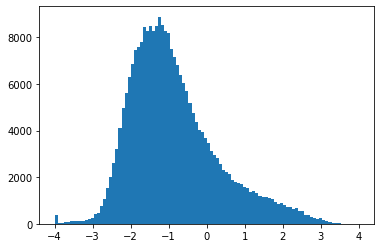

In [11]:
plt.hist(gdsc1_prep["pIC50"], bins=100)
plt.show()

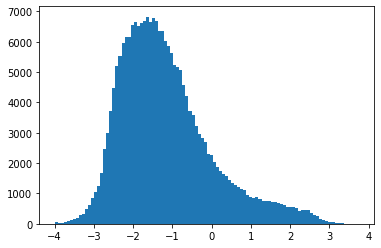

In [12]:
plt.hist(gdsc2_prep["pIC50"], bins=100)
plt.show()